In [1]:
# ============================
# Standard Library
# ============================
import os
import re
import json
import time
import copy
import datetime
import random
from collections import Counter
import warnings

# ============================
# Scientific / Numerical
# ============================
import numpy as np
import pandas as pd
from scipy.stats import sem, tstd

# ============================
# Visualization
# ============================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Machine Learning (sklearn)
# ============================
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    make_scorer, accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report, recall_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    LeaveOneOut, GridSearchCV, StratifiedKFold, train_test_split,
    KFold, ParameterGrid, cross_val_score
)
from sklearn.utils import resample
from sklearn.inspection import permutation_importance

# ============================
# Gradient Boosting Models
# ============================
from xgboost import XGBClassifier

# ============================
# Computer Vision
# ============================
import cv2

# ============================
# Utility Libraries
# ============================
from tqdm import tqdm
import joblib

# ============================
# Warnings
# ============================
warnings.filterwarnings("ignore")


In [2]:
KEYPOINT_NAMES = ['nose',      # 0
                  'head',      # 1
                  'left_ear',  # 2
                  'right_ear', # 3
                  'neck',      # 4
                  'spine_center',  # 5
                  'lumbar_spine',  # 6
                  'tail_base']  # 7

IDX_NOSE     = 0  # nose
IDX_HEAD     = 1  # head
IDX_LEFT_EAR = 2  # left_ear
IDX_RIGHT_EAR= 3  # right_ear
IDX_NECK     = 4  # neck
IDX_SPINE_CENTER      = 5  # spine_center
IDX_LUMBAR_SPINE      = 6  # lumbar_spine
IDX_TAIL_BASE         = 7  # tail_base

In [3]:
df_all = pd.read_pickle("./PyMouseTrack_behaviors_dataframe_3d_realtime.pkl")
df_all.loc[df_all["label"] == 1, "label"] = 2
# 筛选出 label != 0 的行
non_zero_df = df_all[df_all["label"] != 0]

# 对筛选后的 df 在 "label" 列上做频数统计
counts = non_zero_df["label"].value_counts()

print("非 0 label 各类别的行数：")
print(counts)

非 0 label 各类别的行数：
label
5.0    32938
4.0    20786
3.0     9591
2.0     2926
Name: count, dtype: int64


In [4]:
df_all

,nose_3d_x,nose_3d_y,nose_3d_z,head_3d_x,head_3d_y,head_3d_z,left_ear_3d_x,left_ear_3d_y,left_ear_3d_z,right_ear_3d_x,...,nose_pixel_change,head_pixel_change,left_ear_pixel_change,right_ear_pixel_change,neck_pixel_change,spine_center_pixel_change,lumbar_spine_pixel_change,tail_base_pixel_change,label,video_id
0,-13.189177,102.546532,-1.68750,-7.828320,85.585030,6.75000,-19.238787,74.275589,5.75000,5.672549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000429,NaN,Pre_stroke_P3
1,-5.094568,100.460686,-2.43750,-2.435660,84.374100,5.00000,-14.125089,74.622391,2.56250,10.848452,...,24.653263,125.113022,31.061577,3.959303,8470.517578,0.0,3.125000,74.328369,4.0,Pre_stroke_P3
2,-4.934786,100.403671,-2.43750,-2.318096,84.311867,4.75000,-14.043397,74.587288,3.50000,10.964928,...,0.010139,0.036427,0.000035,0.017854,0.000000,0.0,0.000000,0.003257,4.0,Pre_stroke_P3
3,-5.459380,100.185890,-2.43750,-2.688152,84.138535,5.93750,-14.256529,74.352203,4.56250,10.601063,...,0.088202,0.180348,0.087630,0.033210,1.857143,0.0,0.201770,0.119672,4.0,Pre_stroke_P3
4,-5.370100,100.052406,-2.31250,-2.627403,83.987480,5.93750,-14.225748,74.208916,4.43750,10.686395,...,0.000000,0.000000,0.000074,0.008179,0.000000,0.0,0.041894,0.003273,4.0,Pre_stroke_P3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231890,2.896312,71.893051,7.00000,0.091733,59.629795,35.59375,-11.347044,55.439186,32.46875,8.821261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,5.0,1_Day_post_P3
231891,10.574163,71.121155,2.31250,6.218040,61.173546,27.62500,-3.079914,59.321480,27.56250,13.617643,...,15.810706,47.239151,33.014317,488.605469,0.000000,0.0,22.334534,11.604265,4.0,1_Day_post_P3
231892,10.395113,71.211861,2.09375,6.090794,61.234028,27.78125,-3.196902,59.347660,28.03125,13.520516,...,0.003478,0.101199,0.062676,0.033413,0.000000,0.0,0.061151,0.004412,NaN,1_Day_post_P3
231893,10.585110,71.129814,2.21875,6.231027,61.145050,27.75000,-3.088338,59.285015,28.00000,13.640926,...,0.004294,0.000000,0.000000,0.020076,0.000000,0.0,0.000000,0.000000,NaN,1_Day_post_P3


In [5]:
import sklearn
print(sklearn.__version__)

1.5.2


In [6]:
# (1) Define target count and label mapping
target_count = 2926

behavior_map = {
    2: "Grooming",
    3: "Rearing",
    4: "Locomotion",
    5: "Stationary"
}
df_final = df_all

# (2) Count samples for each class
df_valid = df_final[df_final['label'] != 0]
label_counts = df_valid["label"].value_counts()

# (3) Process each class according to its sample size
df_resampled_list = []

for label, count in label_counts.items():
    df_label = df_valid[df_valid["label"] == label]

    if count > target_count:
        # Downsample to target count
        df_downsampled = resample(df_label, replace=False, n_samples=target_count, random_state=42)
        df_resampled_list.append(df_label)
    else:
        df_resampled_list.append(df_label)

# (4) Merge all processed data
df_final = pd.concat(df_resampled_list, ignore_index=True)
df_final["label"] = df_final["label"].replace(behavior_map)

# Extract final features and labels
X_final = df_final.iloc[:, :-2]
y_final = df_final["label"].values

In [7]:
def undersample_majority(X, y, random_state=42):
    """
    Perform majority-class undersampling on the training set:
      - Find the minimum class sample count (min_count)
      - For each class c: if its sample count > min_count, randomly sample (without replacement) down to min_count
      - If its sample count <= min_count, keep all samples
    Return the new undersampled X_us and y_us.
    """
    rng = np.random.default_rng(random_state)
    unique_labels = np.unique(y)
    
    # Count samples for each class
    counts = [np.sum(y == c) for c in unique_labels]
    min_count = np.min(counts)
    
    X_res_list = []
    y_res_list = []
    
    for c in unique_labels:
        X_c = X[y == c]
        n_c = len(X_c)
        if n_c > min_count:
            # Undersample to min_count (random sampling without replacement)
            indices = rng.choice(n_c, size=min_count, replace=False)
            X_us_c = X_c[indices]
            y_us_c = np.array([c] * min_count, dtype=y.dtype)
        else:
            # No undersampling needed
            X_us_c = X_c
            y_us_c = np.array([c] * len(X_c), dtype=y.dtype)
        
        X_res_list.append(X_us_c)
        y_res_list.append(y_us_c)
    
    # Merge all classes
    X_us = np.vstack(X_res_list)
    y_us = np.concatenate(y_res_list)
    
    # Shuffle
    shuffle_idx = rng.permutation(len(y_us))
    X_us = X_us[shuffle_idx]
    y_us = y_us[shuffle_idx]
    
    return X_us, y_us

Classes: ['Grooming' 'Locomotion' 'Rearing' 'Stationary']
Total samples: 66241
Number of groups (windows): 13249

Fold 1: #train=52991, #test=13250
  Original class counts in train: [ 2341 16629  7671 26350]
  After undersampling (multi-class): [2341 2341 2341 2341]
  Class counts in test : [ 585 4157 1920 6588]
    Class 'Grooming': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Locomotion': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Rearing': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Stationary': pos=2341, neg=7023, scale_pos_weight=3.00
  Macro-Sens (OVR) = 0.888, Macro-F1 (OVR) = 0.820

Fold 2: #train=52991, #test=13250
  Original class counts in train: [ 2341 16631  7671 26348]
  After undersampling (multi-class): [2341 2341 2341 2341]
  Class counts in test : [ 585 4155 1920 6590]
    Class 'Grooming': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Locomotion': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Rearing': pos=2341, neg=7023, scal

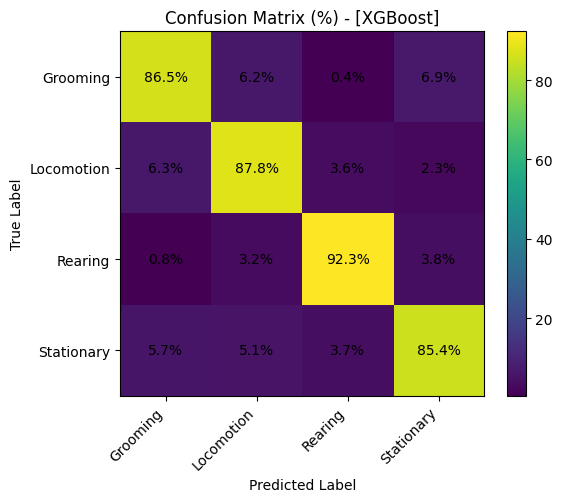

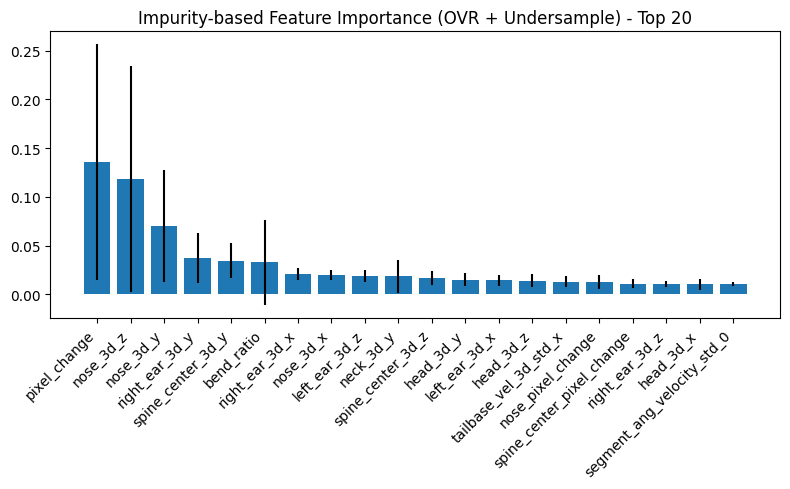

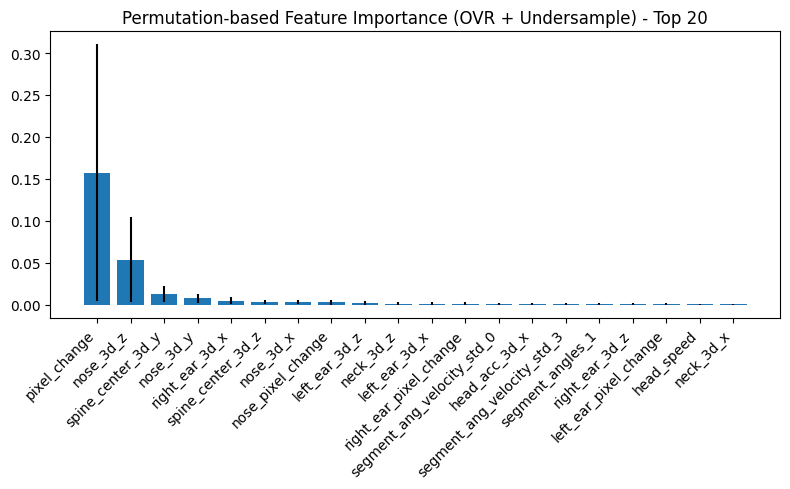

In [8]:
# 1) Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_final)
class_names = label_encoder.classes_
n_classes = len(class_names)
print("Classes:", class_names)

# If X_final is a DataFrame, keep its column names
if isinstance(X_final, pd.DataFrame):
    feature_names = X_final.columns
    X_data = X_final.values
else:
    X_data = X_final
    feature_names = [f"Feature_{i}" for i in range(X_data.shape[1])]

n_samples = len(X_data)
print(f"Total samples: {n_samples}")

# 2) Build "group indices" (time windows); every `window_size` consecutive samples
#    are treated as one group for cross-validation (to avoid temporal leakage).
window_size = 5
groups = np.arange(n_samples) // window_size  
unique_groups = np.unique(groups)
print("Number of groups (windows):", len(unique_groups))

# For each group, define a "dominant label" via majority vote
dominant_labels_for_groups = []
for g in unique_groups:
    idx_g = np.where(groups == g)[0]       
    y_g = y_encoded[idx_g]
    counts = np.bincount(y_g, minlength=n_classes)
    dom_label = np.argmax(counts)
    dominant_labels_for_groups.append(dom_label)
dominant_labels_for_groups = np.array(dominant_labels_for_groups)

# 3) StratifiedKFold on the group level
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# Structures for reporting
# -----------------------------
# For each class, store per-fold sensitivity / F1 from its own binary classifier
class_sens_scores = {c: [] for c in range(n_classes)}
class_f1_scores   = {c: [] for c in range(n_classes)}

# Overall macro-average metrics (based on the multi-class prediction obtained
# by combining one-vs-rest classifiers)
macro_sens_scores = []
macro_f1_scores   = []

# Accumulated confusion matrix across folds (shape = (n_classes, n_classes))
accum_cm = np.zeros((n_classes, n_classes), dtype=int)

# =========== Store feature importances from all (fold × class) models ==========
all_impurity_importances = []
all_perm_importances     = []

fold_idx = 0

# 4) Use StratifiedKFold on the group level to construct 5 folds
for train_group_idx, test_group_idx in skf.split(unique_groups, dominant_labels_for_groups):
    fold_idx += 1
    
    # Map group indices back to sample indices
    train_idx = np.where(np.isin(groups, unique_groups[train_group_idx]))[0]
    test_idx  = np.where(np.isin(groups, unique_groups[test_group_idx]))[0]

    # (a) Multi-class train / test split
    X_train, y_train = X_data[train_idx], y_encoded[train_idx]
    X_test,  y_test  = X_data[test_idx],  y_encoded[test_idx]
    
    # (b) ========== Multi-class majority undersampling on the training set ==========
    X_train_us, y_train_us = undersample_majority(X_train, y_train, random_state=42)

    print(f"\nFold {fold_idx}: #train={len(train_idx)}, #test={len(test_idx)}")
    print(f"  Original class counts in train: {np.bincount(y_train, minlength=n_classes)}")
    print(f"  After undersampling (multi-class): {np.bincount(y_train_us, minlength=n_classes)}")
    print(f"  Class counts in test : {np.bincount(y_test, minlength=n_classes)}")

    # Store, for each test sample, the "positive" probability for each class
    # from its own one-vs-rest classifier
    proba_ovr = np.zeros((len(y_test), n_classes), dtype=np.float32)

    # ---- One-vs-rest: train an independent binary classifier per class ----
    for c in range(n_classes):
        cls_name = class_names[c]

        # Binary labels for the undersampled training set: current class = 1, others = 0
        y_train_bin = (y_train_us == c).astype(int)
        y_test_bin  = (y_test      == c).astype(int)

        pos_count = np.sum(y_train_bin == 1)
        neg_count = np.sum(y_train_bin == 0)

        if pos_count == 0:
            # Extreme case: after undersampling, no positive sample remains in this fold
            print(f"    [WARN] Fold {fold_idx}, class '{cls_name}' has no positive "
                  f"samples in training (after undersampling). Skipping.")
            class_sens_scores[c].append(np.nan)
            class_f1_scores[c].append(np.nan)
            # proba_ovr[:, c] remains zeros
            continue

        # Use scale_pos_weight = (number of negatives / number of positives)
        # so XGBoost automatically rescales the loss function (class imbalance).
        scale_pos_weight = neg_count / pos_count
        print(f"    Class '{cls_name}': pos={pos_count}, neg={neg_count}, "
              f"scale_pos_weight={scale_pos_weight:.2f}")

        # Build the XGBoost binary classifier
        model_c = XGBClassifier(
            random_state=42,
            tree_method='hist',
            objective='binary:logistic',
            scale_pos_weight=scale_pos_weight,
            eval_metric='logloss'
        )

        # Train this class's one-vs-rest classifier on the undersampled training set
        model_c.fit(X_train_us, y_train_bin)

        # Predict the "positive" probability for this class on the test set
        y_proba_pos = model_c.predict_proba(X_test)[:, 1]
        proba_ovr[:, c] = y_proba_pos

        # Use 0.5 as the threshold for the binary prediction of this class
        # (only for per-class sensitivity / F1)
        y_pred_bin = (y_proba_pos >= 0.5).astype(int)

        if np.sum(y_test_bin) == 0:
            sens_c = np.nan
            f1_c   = np.nan
        else:
            sens_c = recall_score(y_test_bin, y_pred_bin, pos_label=1)
            f1_c   = f1_score(y_test_bin, y_pred_bin, pos_label=1)
        class_sens_scores[c].append(sens_c)
        class_f1_scores[c].append(f1_c)

        # ---- Feature importance for this class's binary model ----
        all_impurity_importances.append(model_c.feature_importances_)

        perm_result = permutation_importance(
            model_c, X_test, y_test_bin,
            n_repeats=5, random_state=42, n_jobs=-1
        )
        all_perm_importances.append(perm_result.importances_mean)

    # ---- Combine one-vs-rest probabilities into final multi-class prediction ----
    y_pred_multiclass = np.argmax(proba_ovr, axis=1)

    # Macro-averaged recall / F1 for multi-class behavior classification
    macro_sens = recall_score(y_test, y_pred_multiclass, average='macro')
    macro_f1   = f1_score(y_test, y_pred_multiclass, average='macro')
    macro_sens_scores.append(macro_sens)
    macro_f1_scores.append(macro_f1)

    print(f"  Macro-Sens (OVR) = {macro_sens:.3f}, Macro-F1 (OVR) = {macro_f1:.3f}")

    # Accumulate multi-class confusion matrix
    cm_fold = confusion_matrix(y_test, y_pred_multiclass, labels=range(n_classes))
    accum_cm += cm_fold

# 5) Aggregate per-class results over folds
#    (each class is evaluated by its own binary classifier)
print("\n===== Per-Class OVR Binary Results over 5 Folds =====")
for c in range(n_classes):
    cls_name = class_names[c]
    valid_sens = [s for s in class_sens_scores[c] if not np.isnan(s)]
    valid_f1   = [f for f in class_f1_scores[c]   if not np.isnan(f)]
    
    if len(valid_sens) == 0:
        mean_sens, std_sens = np.nan, np.nan
    else:
        mean_sens = np.mean(valid_sens)
        std_sens  = np.std(valid_sens)
    
    if len(valid_f1) == 0:
        mean_f1, std_f1 = np.nan, np.nan
    else:
        mean_f1  = np.mean(valid_f1)
        std_f1   = np.std(valid_f1)
    
    print(f"Class={cls_name}: Sens={mean_sens:.3f}±{std_sens:.3f}, "
          f"F1={mean_f1:.3f}±{std_f1:.3f}")

# 6) Overall macro-averaged metrics across folds
#    (based on the combined one-vs-rest multi-class prediction)
macro_sens_mean = np.mean(macro_sens_scores)
macro_sens_std  = np.std(macro_sens_scores)
macro_f1_mean   = np.mean(macro_f1_scores)
macro_f1_std    = np.std(macro_f1_scores)

print("\n===== Overall (Macro, OVR + Undersample) 5-Fold =====")
print(f"Macro Sens: {macro_sens_mean:.3f}±{macro_sens_std:.3f}")
print(f"Macro F1  : {macro_f1_mean:.3f}±{macro_f1_std:.3f}")

# 7) Visualize accumulated confusion matrix over 5 folds
row_sums = accum_cm.sum(axis=1, keepdims=True)
cm_perc = accum_cm / row_sums * 100.0

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_perc)
ax.set_title("Confusion Matrix (%) - [XGBoost]")
ax.set_xticks(range(n_classes))
ax.set_yticks(range(n_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

for i in range(n_classes):
    for j in range(n_classes):
        ax.text(j, i, f"{cm_perc[i, j]:.1f}%", ha='center', va='center')

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# ============ Feature importance visualization (Top 20) ===============
all_impurity_importances = np.array(all_impurity_importances)  # (n_models, n_features)
all_perm_importances     = np.array(all_perm_importances)      # (n_models, n_features)

# Average & std across all (class × fold) models
impurity_mean = all_impurity_importances.mean(axis=0)
impurity_std  = all_impurity_importances.std(axis=0)

perm_mean     = all_perm_importances.mean(axis=0)
perm_std      = all_perm_importances.std(axis=0)

top_k = 20

# 1) Impurity-based importance
idx_imp = np.argsort(impurity_mean)[::-1][:top_k]
sorted_imp_mean = impurity_mean[idx_imp]
sorted_imp_std  = impurity_std[idx_imp]
sorted_imp_features = np.array(feature_names)[idx_imp]

plt.figure(figsize=(8,5))
plt.bar(range(top_k), sorted_imp_mean, yerr=sorted_imp_std)
plt.xticks(range(top_k), sorted_imp_features, rotation=45, ha="right")
plt.title("Impurity-based Feature Importance (OVR + Undersample) - Top 20")
plt.tight_layout()
plt.show()

# 2) Permutation-based importance
idx_perm = np.argsort(perm_mean)[::-1][:top_k]
sorted_perm_mean = perm_mean[idx_perm]
sorted_perm_std  = perm_std[idx_perm]
sorted_perm_features = np.array(feature_names)[idx_perm]

plt.figure(figsize=(8,5))
plt.bar(range(top_k), sorted_perm_mean, yerr=sorted_perm_std)
plt.xticks(range(top_k), sorted_perm_features, rotation=45, ha="right")
plt.title("Permutation-based Feature Importance (OVR + Undersample) - Top 20")
plt.tight_layout()
plt.show()

In [9]:
# 1) Features that only depend on 1 or 2 frames for real-time classification
keys_list = [
    'nose_3d_z',
    'pixel_change',
    'nose_3d_y',
    'neck_3d_y',
    'bend_ratio',
    'head_3d_y',
    'spine_center_3d_y',
    'left_ear_3d_y',
    'right_ear_3d_z',
    'right_ear_3d_y',
    'spine_center_3d_z',
    'left_ear_3d_z',
    'segment_angles_0',
    'neck_3d_z',
    'lumbar_spine_3d_z',
    'segment_angles_2',
    'nose_3d_x',
    'head_3d_z',
    'tail_speed',
    'head_speed',
    'lumbar_spine_3d_y',
    'neck_3d_x',
    'segment_angles_1',
    'right_ear_3d_x',
    'left_ear_3d_x',
    'segment_angles_3',
    'head_3d_x',
    'spine_center_3d_x',
    'head_vel_3d_z'
]

# 2) From X_final.columns, select columns whose names contain any of these keys
cols_to_keep = [
    col for col in X_final.columns
    if any(key in col for key in keys_list)
]

# 3) Use these columns to form a new DataFrame
X_filtered = X_final[keys_list]

print(f"Original X_final has {X_final.shape[1]} columns; after filtering {X_filtered.shape[1]} columns remain.")
print("Kept columns:", X_filtered.columns.tolist())

Original X_final has 74 columns; after filtering 29 columns remain.
Kept columns: ['nose_3d_z', 'pixel_change', 'nose_3d_y', 'neck_3d_y', 'bend_ratio', 'head_3d_y', 'spine_center_3d_y', 'left_ear_3d_y', 'right_ear_3d_z', 'right_ear_3d_y', 'spine_center_3d_z', 'left_ear_3d_z', 'segment_angles_0', 'neck_3d_z', 'lumbar_spine_3d_z', 'segment_angles_2', 'nose_3d_x', 'head_3d_z', 'tail_speed', 'head_speed', 'lumbar_spine_3d_y', 'neck_3d_x', 'segment_angles_1', 'right_ear_3d_x', 'left_ear_3d_x', 'segment_angles_3', 'head_3d_x', 'spine_center_3d_x', 'head_vel_3d_z']


Classes: ['Grooming' 'Locomotion' 'Rearing' 'Stationary']
Total samples: 66241
Number of groups (windows): 13249

Fold 1: #train=52991, #test=13250
  Original class counts in train: [ 2341 16629  7671 26350]
  After undersampling (multi-class): [2341 2341 2341 2341]
  Class counts in test : [ 585 4157 1920 6588]
    Class 'Grooming': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Locomotion': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Rearing': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Stationary': pos=2341, neg=7023, scale_pos_weight=3.00
  Macro-Sens (OVR) = 0.885, Macro-F1 (OVR) = 0.817

Fold 2: #train=52991, #test=13250
  Original class counts in train: [ 2341 16631  7671 26348]
  After undersampling (multi-class): [2341 2341 2341 2341]
  Class counts in test : [ 585 4155 1920 6590]
    Class 'Grooming': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Locomotion': pos=2341, neg=7023, scale_pos_weight=3.00
    Class 'Rearing': pos=2341, neg=7023, scal

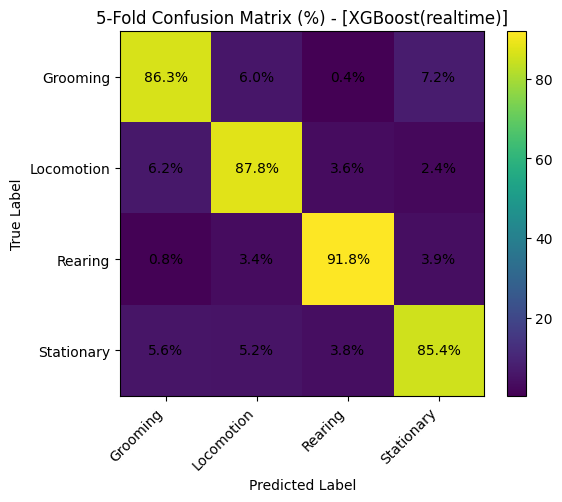

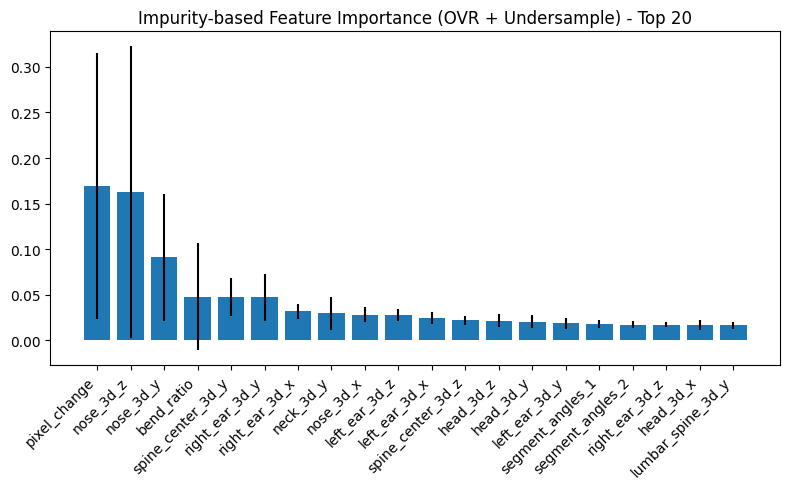

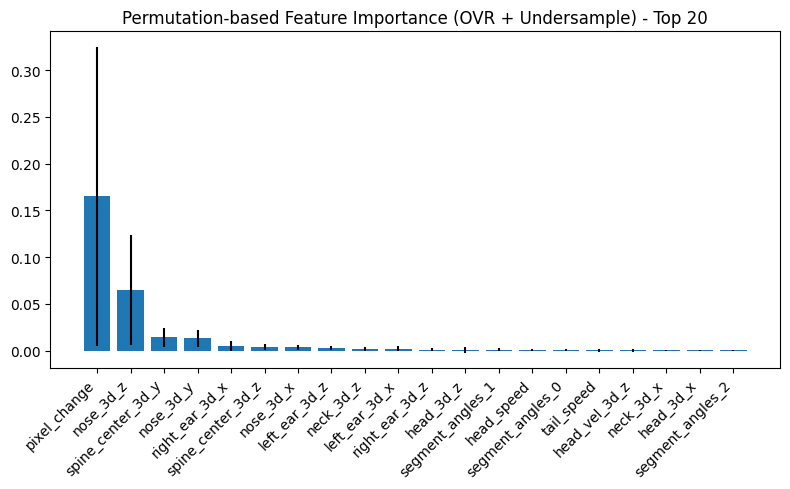

In [10]:
# 1) Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_final)
class_names = label_encoder.classes_
n_classes = len(class_names)
print("Classes:", class_names)

# If X_final is a DataFrame, keep its column names
if isinstance(X_filtered, pd.DataFrame):
    feature_names = X_filtered.columns
    X_data = X_filtered.values
else:
    X_data = X_filtered
    feature_names = [f"Feature_{i}" for i in range(X_data.shape[1])]

n_samples = len(X_data)
print(f"Total samples: {n_samples}")

# 2) Build "group indices" (time windows); every `window_size` consecutive samples
#    are treated as one group for cross-validation (to avoid temporal leakage).
window_size = 5
groups = np.arange(n_samples) // window_size  
unique_groups = np.unique(groups)
print("Number of groups (windows):", len(unique_groups))

# For each group, define a "dominant label" via majority vote
dominant_labels_for_groups = []
for g in unique_groups:
    idx_g = np.where(groups == g)[0]       
    y_g = y_encoded[idx_g]
    counts = np.bincount(y_g, minlength=n_classes)
    dom_label = np.argmax(counts)
    dominant_labels_for_groups.append(dom_label)
dominant_labels_for_groups = np.array(dominant_labels_for_groups)

# 3) StratifiedKFold on the group level
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# Structures for reporting
# -----------------------------
# For each class, store per-fold sensitivity / F1 from its own binary classifier
class_sens_scores = {c: [] for c in range(n_classes)}
class_f1_scores   = {c: [] for c in range(n_classes)}

# Overall macro-average metrics (based on the multi-class prediction obtained
# by combining one-vs-rest classifiers)
macro_sens_scores = []
macro_f1_scores   = []

# Accumulated confusion matrix across folds (shape = (n_classes, n_classes))
accum_cm = np.zeros((n_classes, n_classes), dtype=int)

# =========== Store feature importances from all (fold × class) models ==========
all_impurity_importances = []
all_perm_importances     = []

fold_idx = 0

# 4) Use StratifiedKFold on the group level to construct 5 folds
for train_group_idx, test_group_idx in skf.split(unique_groups, dominant_labels_for_groups):
    fold_idx += 1
    
    # Map group indices back to sample indices
    train_idx = np.where(np.isin(groups, unique_groups[train_group_idx]))[0]
    test_idx  = np.where(np.isin(groups, unique_groups[test_group_idx]))[0]

    # (a) Multi-class train / test split
    X_train, y_train = X_data[train_idx], y_encoded[train_idx]
    X_test,  y_test  = X_data[test_idx],  y_encoded[test_idx]
    
    # (b) ========== Multi-class majority undersampling on the training set ==========
    X_train_us, y_train_us = undersample_majority(X_train, y_train, random_state=42)

    print(f"\nFold {fold_idx}: #train={len(train_idx)}, #test={len(test_idx)}")
    print(f"  Original class counts in train: {np.bincount(y_train, minlength=n_classes)}")
    print(f"  After undersampling (multi-class): {np.bincount(y_train_us, minlength=n_classes)}")
    print(f"  Class counts in test : {np.bincount(y_test, minlength=n_classes)}")

    # Store, for each test sample, the "positive" probability for each class
    # from its own one-vs-rest classifier
    proba_ovr = np.zeros((len(y_test), n_classes), dtype=np.float32)

    # ---- One-vs-rest: train an independent binary classifier per class ----
    for c in range(n_classes):
        cls_name = class_names[c]

        # Binary labels for the undersampled training set: current class = 1, others = 0
        y_train_bin = (y_train_us == c).astype(int)
        y_test_bin  = (y_test      == c).astype(int)

        pos_count = np.sum(y_train_bin == 1)
        neg_count = np.sum(y_train_bin == 0)

        if pos_count == 0:
            # Extreme case: after undersampling, no positive sample remains in this fold
            print(f"    [WARN] Fold {fold_idx}, class '{cls_name}' has no positive "
                  f"samples in training (after undersampling). Skipping.")
            class_sens_scores[c].append(np.nan)
            class_f1_scores[c].append(np.nan)
            # proba_ovr[:, c] remains zeros
            continue

        # Use scale_pos_weight = (number of negatives / number of positives)
        # so XGBoost automatically rescales the loss function (class imbalance).
        scale_pos_weight = neg_count / pos_count
        print(f"    Class '{cls_name}': pos={pos_count}, neg={neg_count}, "
              f"scale_pos_weight={scale_pos_weight:.2f}")

        # Build the XGBoost binary classifier
        model_c = XGBClassifier(
            random_state=42,
            tree_method='hist',
            objective='binary:logistic',
            scale_pos_weight=scale_pos_weight,
            eval_metric='logloss'
        )

        # Train this class's one-vs-rest classifier on the undersampled training set
        model_c.fit(X_train_us, y_train_bin)

        # Predict the "positive" probability for this class on the test set
        y_proba_pos = model_c.predict_proba(X_test)[:, 1]
        proba_ovr[:, c] = y_proba_pos

        # Use 0.5 as the threshold for the binary prediction of this class
        # (only for per-class sensitivity / F1)
        y_pred_bin = (y_proba_pos >= 0.5).astype(int)

        if np.sum(y_test_bin) == 0:
            sens_c = np.nan
            f1_c   = np.nan
        else:
            sens_c = recall_score(y_test_bin, y_pred_bin, pos_label=1)
            f1_c   = f1_score(y_test_bin, y_pred_bin, pos_label=1)
        class_sens_scores[c].append(sens_c)
        class_f1_scores[c].append(f1_c)

        # ---- Feature importance for this class's binary model ----
        all_impurity_importances.append(model_c.feature_importances_)

        perm_result = permutation_importance(
            model_c, X_test, y_test_bin,
            n_repeats=5, random_state=42, n_jobs=-1
        )
        all_perm_importances.append(perm_result.importances_mean)

    # ---- Combine one-vs-rest probabilities into final multi-class prediction ----
    y_pred_multiclass = np.argmax(proba_ovr, axis=1)

    # Macro-averaged recall / F1 for multi-class behavior classification
    macro_sens = recall_score(y_test, y_pred_multiclass, average='macro')
    macro_f1   = f1_score(y_test, y_pred_multiclass, average='macro')
    macro_sens_scores.append(macro_sens)
    macro_f1_scores.append(macro_f1)

    print(f"  Macro-Sens (OVR) = {macro_sens:.3f}, Macro-F1 (OVR) = {macro_f1:.3f}")

    # Accumulate multi-class confusion matrix
    cm_fold = confusion_matrix(y_test, y_pred_multiclass, labels=range(n_classes))
    accum_cm += cm_fold

# 5) Aggregate per-class results over folds
#    (each class is evaluated by its own binary classifier)
print("\n===== Per-Class OVR Binary Results over 5 Folds =====")
for c in range(n_classes):
    cls_name = class_names[c]
    valid_sens = [s for s in class_sens_scores[c] if not np.isnan(s)]
    valid_f1   = [f for f in class_f1_scores[c]   if not np.isnan(f)]
    
    if len(valid_sens) == 0:
        mean_sens, std_sens = np.nan, np.nan
    else:
        mean_sens = np.mean(valid_sens)
        std_sens  = np.std(valid_sens)
    
    if len(valid_f1) == 0:
        mean_f1, std_f1 = np.nan, np.nan
    else:
        mean_f1  = np.mean(valid_f1)
        std_f1   = np.std(valid_f1)
    
    print(f"Class={cls_name}: Sens={mean_sens:.3f}±{std_sens:.3f}, "
          f"F1={mean_f1:.3f}±{std_f1:.3f}")

# 6) Overall macro-averaged metrics across folds
#    (based on the combined one-vs-rest multi-class prediction)
macro_sens_mean = np.mean(macro_sens_scores)
macro_sens_std  = np.std(macro_sens_scores)
macro_f1_mean   = np.mean(macro_f1_scores)
macro_f1_std    = np.std(macro_f1_scores)

print("\n===== Overall (Macro, OVR + Undersample) 5-Fold =====")
print(f"Macro Sens: {macro_sens_mean:.3f}±{macro_sens_std:.3f}")
print(f"Macro F1  : {macro_f1_mean:.3f}±{macro_f1_std:.3f}")

# 7) Visualize accumulated confusion matrix over 5 folds
row_sums = accum_cm.sum(axis=1, keepdims=True)
cm_perc = accum_cm / row_sums * 100.0

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_perc)
ax.set_title("5-Fold Confusion Matrix (%) - [XGBoost(realtime)]")
ax.set_xticks(range(n_classes))
ax.set_yticks(range(n_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

for i in range(n_classes):
    for j in range(n_classes):
        ax.text(j, i, f"{cm_perc[i, j]:.1f}%", ha='center', va='center')

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# ============ Feature importance visualization (Top 20) ===============
all_impurity_importances = np.array(all_impurity_importances)  # (n_models, n_features)
all_perm_importances     = np.array(all_perm_importances)      # (n_models, n_features)

# Average & std across all (class × fold) models
impurity_mean = all_impurity_importances.mean(axis=0)
impurity_std  = all_impurity_importances.std(axis=0)

perm_mean     = all_perm_importances.mean(axis=0)
perm_std      = all_perm_importances.std(axis=0)

top_k = 20

# 1) Impurity-based importance
idx_imp = np.argsort(impurity_mean)[::-1][:top_k]
sorted_imp_mean = impurity_mean[idx_imp]
sorted_imp_std  = impurity_std[idx_imp]
sorted_imp_features = np.array(feature_names)[idx_imp]

plt.figure(figsize=(8,5))
plt.bar(range(top_k), sorted_imp_mean, yerr=sorted_imp_std)
plt.xticks(range(top_k), sorted_imp_features, rotation=45, ha="right")
plt.title("Impurity-based Feature Importance (OVR + Undersample) - Top 20")
plt.tight_layout()
plt.show()

# 2) Permutation-based importance
idx_perm = np.argsort(perm_mean)[::-1][:top_k]
sorted_perm_mean = perm_mean[idx_perm]
sorted_perm_std  = perm_std[idx_perm]
sorted_perm_features = np.array(feature_names)[idx_perm]

plt.figure(figsize=(8,5))
plt.bar(range(top_k), sorted_perm_mean, yerr=sorted_perm_std)
plt.xticks(range(top_k), sorted_perm_features, rotation=45, ha="right")
plt.title("Permutation-based Feature Importance (OVR + Undersample) - Top 20")
plt.tight_layout()
plt.show()